## **Modelo:** Árbol de decision


In [16]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, f1_score, roc_auc_score, precision_score, recall_score, make_scorer
from sklearn import tree  
from sklearn.tree import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
#los parquet ya están divididos entre train, test y validación
ruta_train =  os.path.join("..","..","..", "data", "P2_dif","train.parquet")
train = pd.read_parquet(ruta_train)
train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2010-01-02,Rashad Evans,Thiago Silva,False,-0.3,-0.239,0.230769,-0.2,0.0,1.2,...,17.3,4.0,4.223836,0.5,-0.7,0.0,4.0,-0.3,0.0,1.0
1,2010-01-02,Sam Stout,Joe Lauzon,False,0.5,-0.252,-0.331250,-3.0,0.0,-104.6,...,-2.0,1.0,-2.396327,-0.9,-1.8,-2.5,2.5,-1.0,1.0,2.8
2,2010-01-11,Rafael Dos Anjos,Kyle Bradley,False,0.0,-0.114,-0.082353,1.3,0.3,187.2,...,0.0,0.0,0.000000,0.0,-0.5,0.0,0.5,-0.8,0.0,0.8
3,2010-01-11,Amir Sadollah,Brad Blackburn,False,-1.1,0.048,0.000000,-0.1,0.0,110.6,...,-3.0,0.0,-0.546865,-1.0,-1.0,1.0,-0.8,0.8,0.0,0.0
4,2010-01-11,Gray Maynard,Nate Diaz,False,0.0,0.062,0.142089,-1.3,-0.6,158.4,...,-2.4,-1.0,-0.943809,3.3,1.0,-4.5,3.3,0.0,0.0,-1.8


In [18]:
ruta_val = os.path.join("..","..","..", "data", "P2_dif","validation.parquet")
val = pd.read_parquet(ruta_val)
val.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2021-10-30,Magomed Ankalaev,Volkan Oezdemir,False,0.2,0.074,0.272727,0.0,0.0,157.9,...,0.0,-2.0,62.537106,3.0,0.8,0.0,-0.3,-1.5,0.0,-1.0
1,2021-10-30,Jan Blachowicz,Glover Teixeira,True,0.2,-0.173,0.031746,-1.4,-0.4,-253.0,...,-23.3,-4.0,92.929969,0.0,-2.0,-3.5,1.5,-1.0,0.0,1.0
2,2021-10-30,Alexander Volkov,Marcin Tybura,False,0.3,0.088,-0.263158,0.0,0.0,-128.4,...,10.0,-4.0,9.933111,-2.0,0.5,0.0,-2.0,-2.0,0.0,-0.5
3,2021-10-30,Makwan Amirkhani,Lerone Murphy,True,0.0,-0.090,0.257778,-0.2,-0.2,78.4,...,3.0,7.0,8.305570,-1.0,0.2,3.0,0.5,1.0,0.0,2.3
4,2021-10-30,Amanda Ribas,Virna Jandiroba,False,0.0,-0.015,0.083333,-0.2,0.2,128.1,...,-7.0,0.0,37.406009,2.5,-0.5,-0.2,2.0,0.5,0.0,-1.8


OBJETIVO

El objetivo de hacer un árbol de decisión no es tanto sacar los resultados más óptimos, sino ver las variables que tienen más importancia.

TRANSFORMACIONES

No es necesario hacer transformaciones para hacer un árbol de decisión ya que estos pueden manejar los datos sin estos cambios.

SELECCIÓN DE VARIABLES

Tampoco es necesario hacer una selección de variables ya que los árboles de decisión no se ven afectados por diferencias en las magnitudes de las variables, además de que el propio árbol selecciona las características más relevantes de las variables.

AJUSTE DE HIPERPARÁMETROS

Para ajustar los parámetros hemos utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. Primero probamos a hacer un modelo con Grid Search.

In [19]:
def train_decision_tree_grid(X_train, y_train, X_val, y_val):
    from sklearn.tree import plot_tree
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    tscv = TimeSeriesSplit(n_splits=5)


    # Definir modelo base
    dt = DecisionTreeClassifier(random_state=42)

    # Cuadrícula de hiperparámetros
    param_grid = {
        'criterion': ['gini', 'entropy'],  # Función para medir la calidad de la división
        'max_depth': [3,5,10],  # Profundidad máxima del árbol
        'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
        'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras en una hoja
        'min_weight_fraction_leaf': [0.01, 0.1, 0.15],
        'splitter': ['best'],
        'class_weight': [None, class_weight_dict],  # Ajuste de pesos por clase
        'max_features': [None, 'sqrt', 'log2']
    }
    

    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda de hiperparámetros con validación cruzada
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        scoring= f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    # Visualización del árbol
    plt.figure(figsize=(15, 8))
    plot_tree(grid_search.best_estimator_, filled=True, feature_names=X_train.columns, class_names=["False", "True"])
    plt.show()

    return grid_search.best_estimator_

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Mejores parámetros: {'class_weight': {0: np.float64(0.883399209486166), 1: np.float64(1.152061855670103)}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.56      0.52      0.54       259
        True       0.48      0.52      0.50       219

    accuracy                           0.52       478
   macro avg       0.52      0.52      0.52       478
weighted avg       0.52      0.52      0.52       478



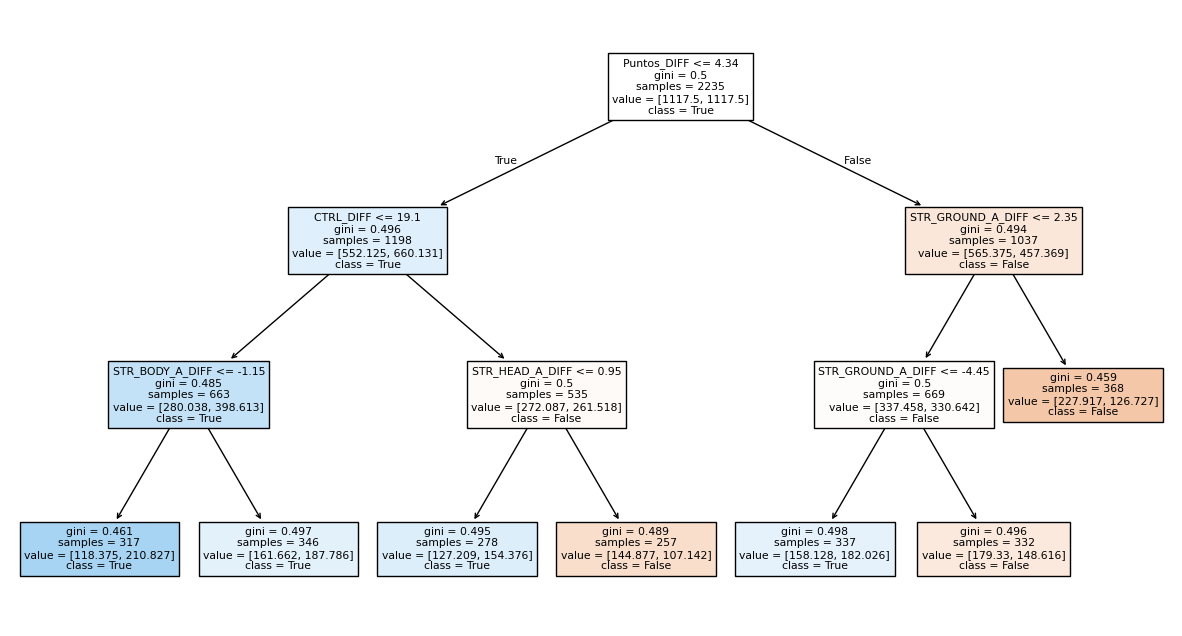

In [20]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"] #categóricas y variable respuesta

X_train = train.drop(columns=columnasQuitar)
y_train = train['WINNER']
X_val = val.drop(columns=columnasQuitar)
y_val = val['WINNER']


tree = train_decision_tree_grid(X_train, y_train, X_val, y_val)

Variables con importancia en el modelo: CTRL_DIFF, Importancia: 0.16238
Variables con importancia en el modelo: STR_HEAD_A_DIFF, Importancia: 0.11581
Variables con importancia en el modelo: STR_BODY_A_DIFF, Importancia: 0.10341
Variables con importancia en el modelo: STR_GROUND_A_DIFF, Importancia: 0.31633
Variables con importancia en el modelo: Puntos_DIFF, Importancia: 0.30207


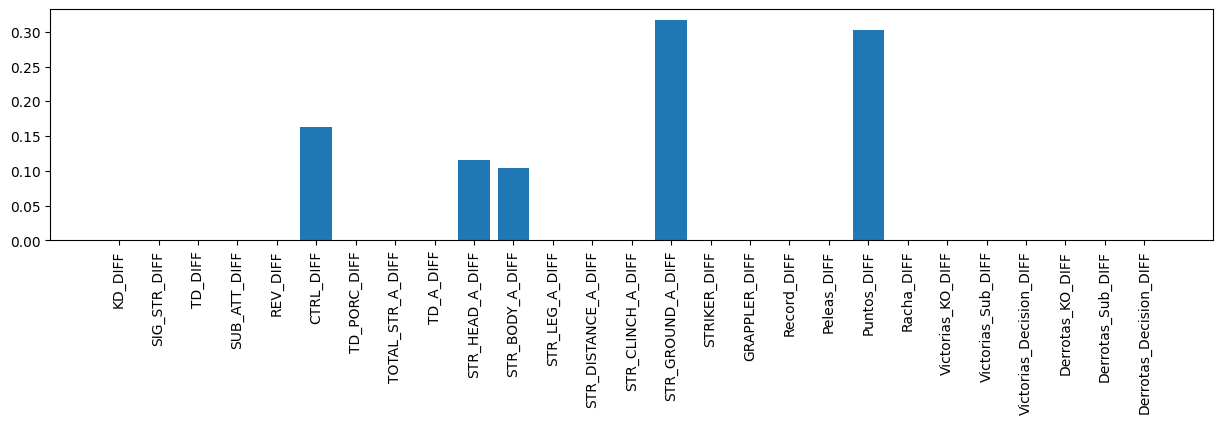

In [21]:
importance = tree.feature_importances_
feature_names=X_train.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

Como vemos el árbol con mejor f1_score tiene max_depth = 3, lo que hace que no haya muchas variables importantes ya que se usan pocas en el modelo.

In [22]:
#Observamos todos los valores de las métricas.
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = tree.predict(X_val)
y_val_prob = tree.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))


-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5209205020920502
F1-Score: 0.4989
AUC-ROC: 0.5181
Precisión: 0.4790
Sensibilidad: 0.5205
Log-loss: 0.6996159801718398
[[135 124]
 [105 114]]


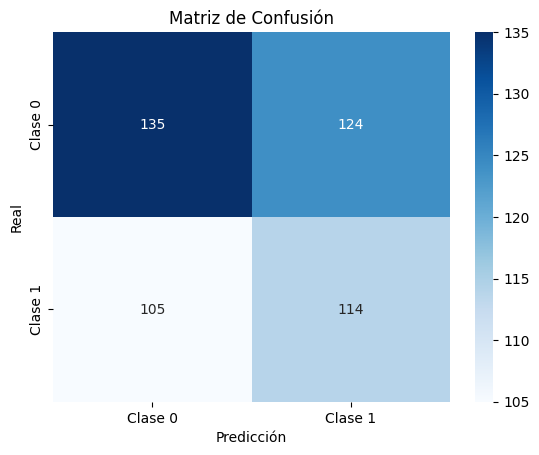

In [23]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Como vemos, con Grid Search el modelo no es bueno ya que ronda el 0.5 en métricas como el f1_score o el accuracy. No obstante, como previamente hemos dicho, este no era el objetivo del modelo. Vamos a probar con Random Search.

In [24]:
def train_decision_tree_random(X_train, y_train, X_val, y_val):
    from sklearn.tree import plot_tree
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
    tscv = TimeSeriesSplit(n_splits=5)

    # Definir modelo base
    dt2 = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3],
    "min_samples_split": [int(x) for x in np.arange(2, 20, 2)],
    "min_samples_leaf": [int(x) for x in np.arange(1, 20, 2)],
    'min_weight_fraction_leaf': [0.1, 0.15, 0.2],
    'splitter': ['best'],
    "max_features": ["sqrt", "log2", None],
    'class_weight': [None, class_weight_dict],  # Ajuste de pesos por clase
    }

    #  ['ccp_alpha', 'class_weight', 'max_leaf_nodes', 'min_impurity_decrease',
    #  'min_weight_fraction_leaf', 'monotonic_cst', 'random_state']  otros posibles parámetros

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=dt2,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )


    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    plt.figure(figsize=(15, 8))
    plot_tree(random_search.best_estimator_, filled=True, feature_names=X_train.columns, class_names=["False", "True"])
    plt.show()

    return random_search.best_estimator_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'splitter': 'best', 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 'log2', 'max_depth': 3, 'criterion': 'entropy', 'class_weight': {np.False_: np.float64(0.883399209486166), np.True_: np.float64(1.152061855670103)}}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.56      0.52      0.54       259
        True       0.48      0.52      0.50       219

    accuracy                           0.52       478
   macro avg       0.52      0.52      0.52       478
weighted avg       0.52      0.52      0.52       478



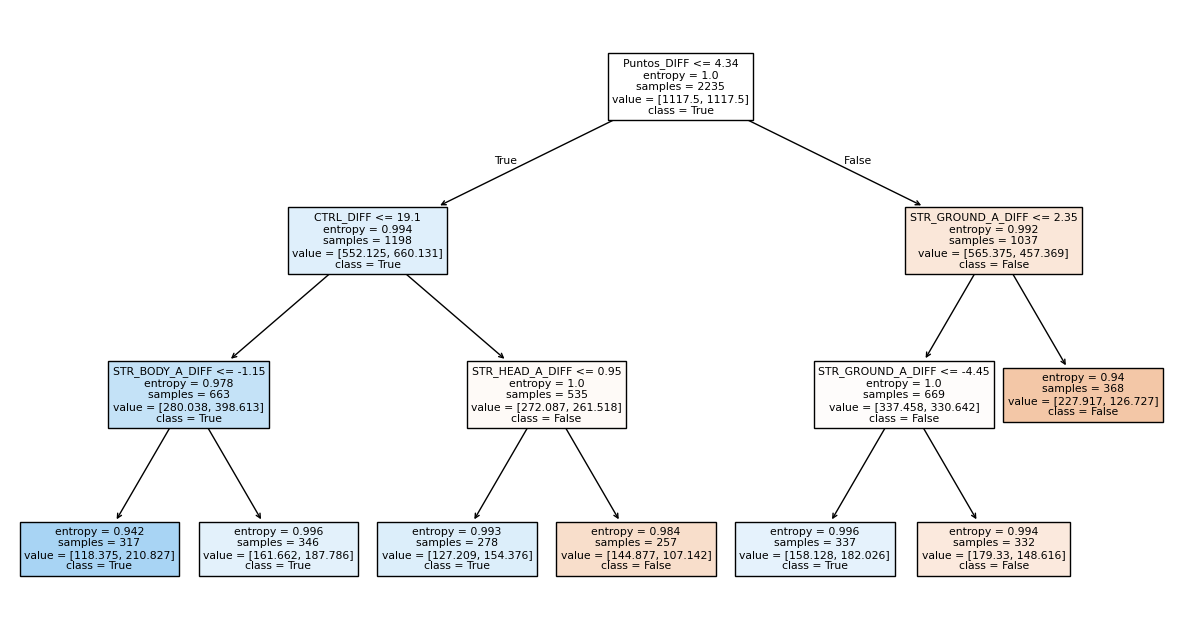

In [25]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
tree2 = train_decision_tree_random(X_train,y_train,X_val,y_val)

Variables con importancia en el modelo: CTRL_DIFF, Importancia: 0.16189
Variables con importancia en el modelo: STR_HEAD_A_DIFF, Importancia: 0.11487
Variables con importancia en el modelo: STR_BODY_A_DIFF, Importancia: 0.10576
Variables con importancia en el modelo: STR_GROUND_A_DIFF, Importancia: 0.31831
Variables con importancia en el modelo: Puntos_DIFF, Importancia: 0.29916


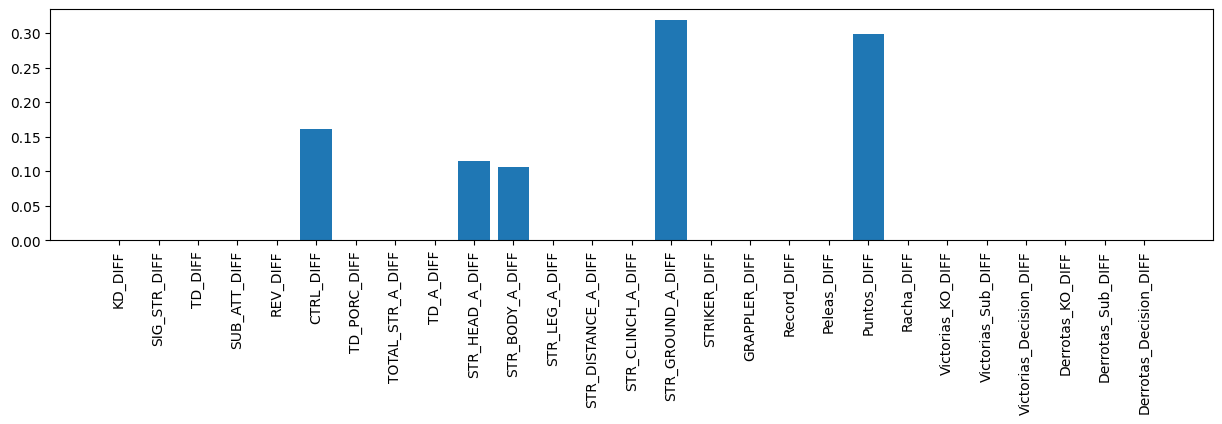

In [26]:
importance = tree2.feature_importances_
feature_names=X_train.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

In [27]:
#Observamos todos los valores de las métricas.
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = tree2.predict(X_val)
y_val_prob = tree2.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)

print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))



-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5209205020920502
F1-Score: 0.4989
AUC-ROC: 0.5181
Precisión: 0.4790
Sensibilidad: 0.5205
Log-loss: 0.6996159801718398
[[135 124]
 [105 114]]


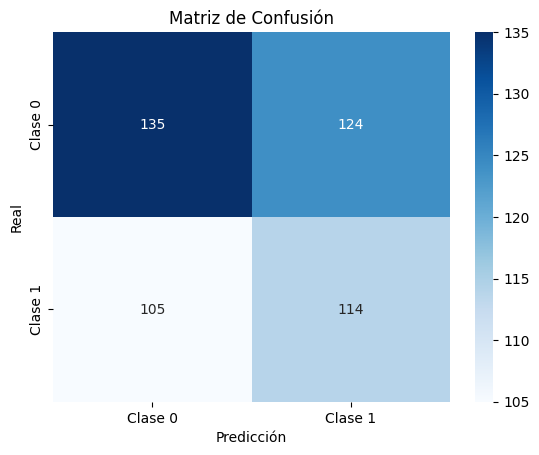

In [28]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

El modelo con Random Search es casi idéntico al realizado con Grid Search anteriormente.